In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
customers.head(1)

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10


In [4]:
products.head(1)

,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.3


In [5]:
transactions.head(1)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68


In [6]:
df = transactions.merge(customers, on="CustomerID", how="inner")

In [7]:
df.shape

(1000, 10)

In [8]:
df.sample(1)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
18,T00938,C0087,P030,2024-02-21 18:51:05,3,833.58,277.86,Travis Campbell,South America,2024-04-11


In [9]:
df=df.merge(products, on="ProductID", how="inner")

In [10]:
df.shape

(1000, 13)

In [11]:
df.sample(2)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
801,T00926,C0181,P054,2024-08-16 02:29:10,3,171.90,57.30,Alexander Barker,South America,2023-11-16,SoundWave Cookbook,Books,57.30
861,T00373,C0179,P082,2024-02-07 20:28:19,2,111.98,55.99,Donald Miller,Europe,2022-10-16,ComfortLiving Rug,Home Decor,55.99


In [12]:

# Convert TransactionDate to datetime for time-based analysis
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])


In [13]:
# Step 1: Feature Engineering

# Add year and month to TransactionDate
df['TransactionYear'] = df['TransactionDate'].dt.year
df['TransactionMonth'] = df['TransactionDate'].dt.month


In [14]:
df.sample()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y,TransactionYear,TransactionMonth
516,T00358,C0154,P034,2024-04-08 20:47:01,1,217.05,217.05,Robert Sharp,North America,2024-10-27,HomeSense T-Shirt,Clothing,217.05,2024,4


In [15]:
# Total transaction value per customer
customer_features = df.groupby('CustomerID').agg({
    'TotalValue': 'sum',             # total spending
    'TransactionID': 'count',        # number of transactions
    'ProductID': 'nunique',          # number of unique products bought
    'Price_x': 'mean',               # average price paid per transaction
    'TransactionYear': 'nunique'     # number of years active
}).reset_index()

In [16]:
customer_features.rename(columns={
    'TotalValue': 'TotalSpending',
    'TransactionID': 'TransactionCount',
    'ProductID': 'UniqueProductsBought',
    'Price_x': 'AvgTransactionValue',
    'TransactionYear': 'ActiveYears'
}, inplace=True)

In [17]:
customer_features.head(1)

,CustomerID,TotalSpending,TransactionCount,UniqueProductsBought,AvgTransactionValue,ActiveYears
0,C0001,3354.52,5,5,278.334,1


In [18]:
# Add the most purchased product category
most_purchased_category = (
    df.groupby(['CustomerID', 'Category'])['Quantity']
    .sum()
    .reset_index()
    .sort_values(['CustomerID', 'Quantity'], ascending=[True, False])
    .drop_duplicates('CustomerID', keep='first')
)
most_purchased_category.rename(columns={'Category': 'TopCategory'}, inplace=True)

In [19]:
most_purchased_category.sample(1)

,CustomerID,TopCategory,Quantity
56,C0022,Clothing,10


In [20]:
# Merge customer features with most purchased category
customer_features = customer_features.merge(most_purchased_category[['CustomerID', 'TopCategory']], on='CustomerID', how='left')


In [21]:
customer_features.head(1)

,CustomerID,TotalSpending,TransactionCount,UniqueProductsBought,AvgTransactionValue,ActiveYears,TopCategory
0,C0001,3354.52,5,5,278.334,1,Electronics


In [22]:
# Step 2: Similarity Calculation

# Encode the categorical 'TopCategory'
encoder = LabelEncoder()
customer_features['TopCategoryEncoded'] = encoder.fit_transform(customer_features['TopCategory'])

# Scale numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[['TotalSpending', 'TransactionCount', 'UniqueProductsBought', 'AvgTransactionValue', 'ActiveYears', 'TopCategoryEncoded']])

# Compute cosine similarity
similarity_matrix = cosine_similarity(scaled_features)


In [23]:

# Convert similarity matrix to DataFrame
similarity_df = pd.DataFrame(similarity_matrix, index=customer_features['CustomerID'], columns=customer_features['CustomerID'])


In [24]:
# Step 3: Get Top 3 Similar Customers

def get_top_similar(customers, similarity_matrix, top_n=3):
    lookalike_map = {}
    for customer in customers:
        similar_customers = similarity_matrix[customer].sort_values(ascending=False).iloc[1:top_n + 1]
        lookalike_map[customer] = list(zip(similar_customers.index, similar_customers.values))
    return lookalike_map



In [25]:
# Generate lookalike recommendations for first 20 customers
first_20_customers = customer_features['CustomerID'][:20]
lookalike_map = get_top_similar(first_20_customers, similarity_df)

# Convert to Lookalike.csv format
lookalike_data = [{'CustomerID': k, 'Lookalikes': v} for k, v in lookalike_map.items()]
lookalike_df = pd.DataFrame(lookalike_data)

# Save recommendations to CSV
lookalike_df.to_csv('Lookalike.csv', index=False)

C:\Users\acer\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


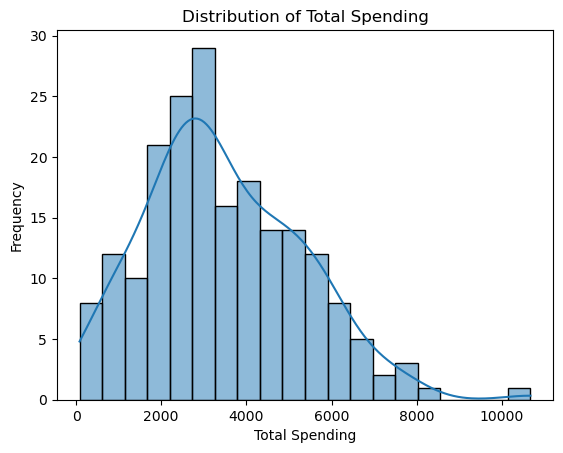

In [26]:
# Step 4: Additional Visualizations

# Distribution of Total Spending

sns.histplot(customer_features['TotalSpending'], kde=True, bins=20)
plt.title('Distribution of Total Spending')
plt.xlabel('Total Spending')
plt.ylabel('Frequency')
plt.show()

C:\Users\acer\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


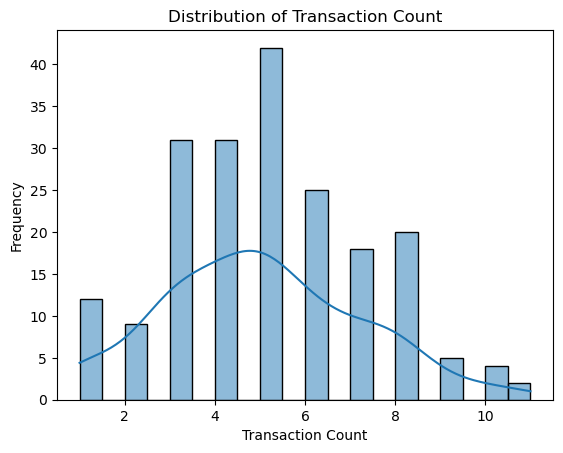

In [27]:
# Distribution of Transaction Count
sns.histplot(customer_features['TransactionCount'], kde=True, bins=20)
plt.title('Distribution of Transaction Count')
plt.xlabel('Transaction Count')
plt.ylabel('Frequency')
plt.show()

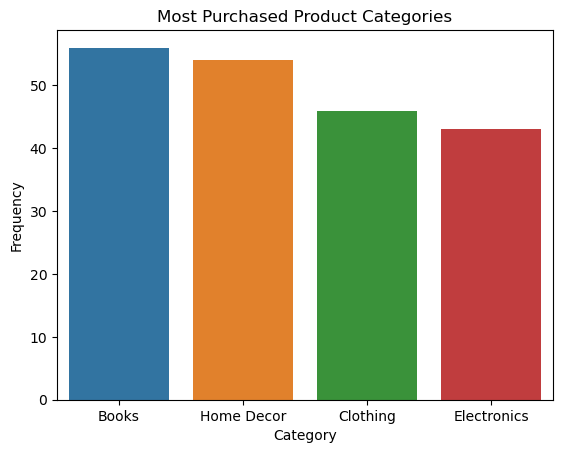

In [28]:
# Top Categories by Frequency
top_categories = most_purchased_category['TopCategory'].value_counts()
sns.barplot(x=top_categories.index, y=top_categories.values)
plt.title('Most Purchased Product Categories')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks()
plt.show()

In [29]:
# Step 5: Quality Check of Recommendations
# Print recommendations for manual validation
print("Top 3 Lookalikes for the first 20 customers:")
for customer, lookalikes in lookalike_map.items():
    print(f"{customer}: {lookalikes}")

Top 3 Lookalikes for the first 20 customers:
C0001: [('C0164', 0.9690507000333249), ('C0152', 0.9436014860832437), ('C0103', 0.9200208862981109)]
C0002: [('C0025', 0.9892661503057171), ('C0071', 0.9693252645669626), ('C0003', 0.9645741920486384)]
C0003: [('C0178', 0.9670190959432479), ('C0002', 0.9645741920486384), ('C0025', 0.9618229895391744)]
C0004: [('C0108', 0.9808272031343382), ('C0113', 0.9744464362023267), ('C0124', 0.9620697392176214)]
C0005: [('C0020', 0.9883314024462088), ('C0130', 0.9881035085307704), ('C0120', 0.9879710401704663)]
C0006: [('C0117', 0.961647367163539), ('C0185', 0.920600350954412), ('C0125', 0.9064118555143358)]
C0007: [('C0085', 0.9999794169587695), ('C0050', 0.9611171613214974), ('C0089', 0.9544038236171517)]
C0008: [('C0109', 0.9791671746850896), ('C0098', 0.9648072068576807), ('C0175', 0.9503822977017069)]
C0009: [('C0150', 0.9527372995541954), ('C0058', 0.9181680353953399), ('C0198', 0.9058387848190499)]
C0010: [('C0121', 0.9688364282096108), ('C0029',